## Treinando UNET para segmentação de sinais e lesões de pele

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

cudnn.benchmark = True

# Clearing the occupied cuda memory
torch.cuda.empty_cache()
import shutil
from torchvision.models.vgg import VGG11_Weights

In [ ]:
# link dataset: https://drive.google.com/file/d/1RpP9-jt24G1HYx817-TbTkYPyBN29xxn/view?usp=sharing

!unzip drive/MyDrive/lesion_segmentation.zip -d ./data

Archive:  drive/MyDrive/lesion_segmentation.zip
   creating: ./data/lesion_segmentation/
   creating: ./data/lesion_segmentation/train/
  inflating: ./data/lesion_segmentation/train/ISIC_0000081.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000000.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000001.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000002.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000004.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000006.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000007.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000008.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000009.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000010.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000011.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000016.jpg  
  inflating: ./data/lesion_segmentation/train/ISIC_0000017.jpg  
  inflating: ./data

### 01 - Dataset loading and preprocess

In [ ]:


train_dir = "./data/lesion_segmentation/train"
valid_dir = "./data/lesion_segmentation/valid"
test_dir  = "./data/lesion_segmentation/test"

train_masks = "./data/lesion_segmentation/train_masks"
valid_masks = "./data/lesion_segmentation/valid_masks"
test_masks  = "./data/lesion_segmentation/test_masks"


train_images = os.listdir(train_dir)
valid_images = os.listdir(valid_dir)
test_images  = os.listdir(test_dir)

MASK_SUFFIX = "_Segmentation"

In [ ]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    image_limit = 5
    rows = image_limit
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 15))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", MASK_SUFFIX+".png")), cv2.IMREAD_UNCHANGED,)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()

        if i == image_limit - 1:
            break
    plt.tight_layout()
    plt.show()


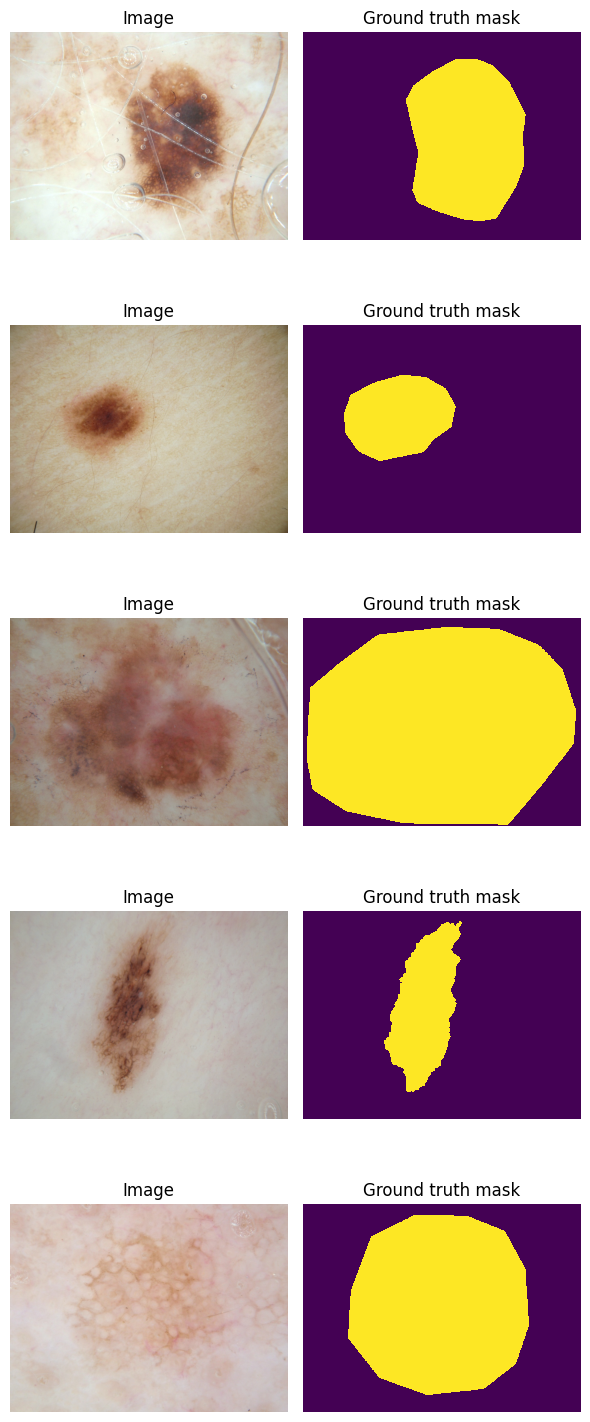

In [ ]:
display_image_grid(valid_images, valid_dir, valid_masks, predicted_masks=None)

In [ ]:
class LesionDataset(Dataset):

    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", MASK_SUFFIX+".png")), cv2.IMREAD_UNCHANGED,

        )

        mask = mask.astype(np.float32)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]/255.0

        return image, mask

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = LesionDataset(train_images, train_dir, train_masks, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = LesionDataset(valid_images, valid_dir, valid_masks, transform=val_transform,)


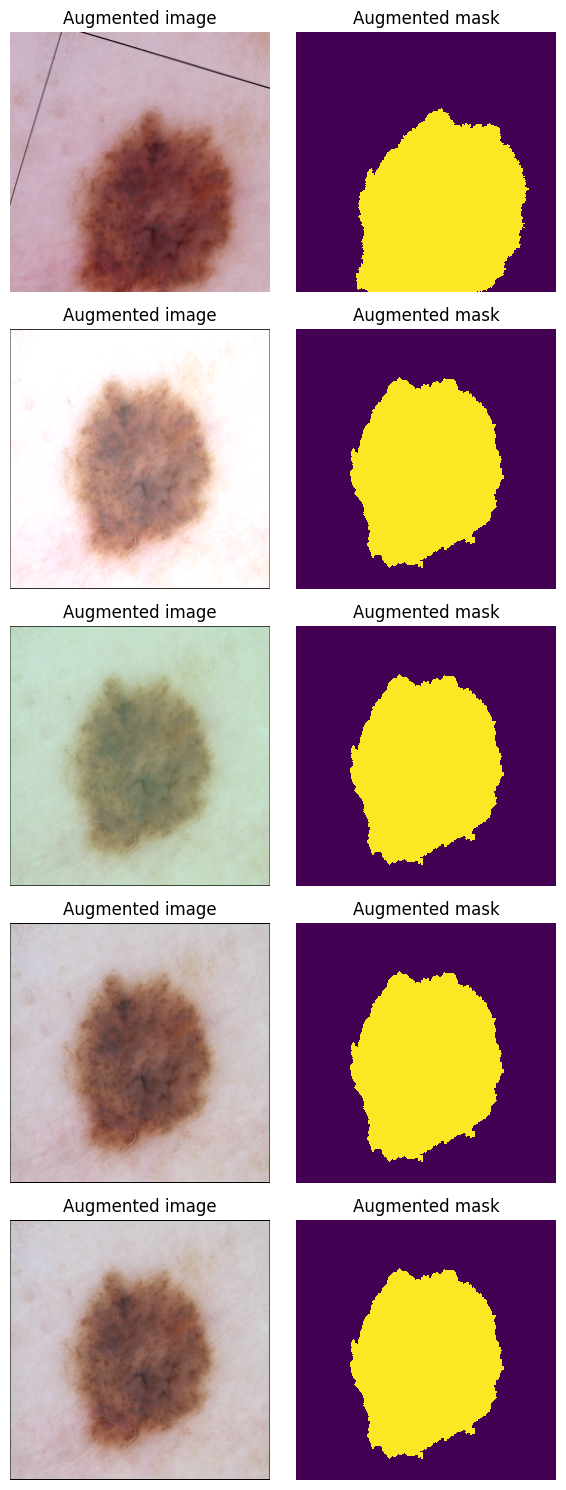

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(6, 15))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()



random.seed(42)
visualize_augmentations(train_dataset, idx=55)

## 02 - Model

In [ ]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

class Block(Module):

	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)

	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

class Encoder(Module):

	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

class Decoder(Module):

	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x

	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

class UNet(Module):

	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(256,  256)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

### 03 - Defining functions for training and validation

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    train_loss = 0
    samples    = 0
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target.float())
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add the loss to the total training loss so far
        train_loss += loss.item()
        samples    += images.shape[0]

        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

    return train_loss/samples

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    valid_loss = 0
    samples    = 0
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target.float())
            metric_monitor.update("Loss", loss.item())

            # add the loss to the total val loss so far
            valid_loss += loss.item()
            samples    += images.shape[0]

            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return valid_loss/samples

In [ ]:
def create_model(params):
    model = UNet()
    model = model.to(params["device"])
    return model



In [ ]:
def train_and_validate(model, train_dataset, val_dataset, params):

    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

    for epoch in range(1, params["epochs"] + 1):
        train_loss = train(train_loader, model, criterion, optimizer, epoch, params)
        valid_loss = validate(val_loader, model, criterion, epoch, params)

        # update our training history
        print(f"Epoch: {epoch} - Train Loss: {train_loss} - Val Loss: {valid_loss}")
        H["train_loss"].append(train_loss)
        H["valid_loss"].append(valid_loss)

    return model

In [ ]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [ ]:
params = {
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 2,
    "epochs": 40,
}

H = {"train_loss": [], "valid_loss": []}

In [ ]:

model = create_model(params)

In [ ]:
model = train_and_validate(model, train_dataset, val_dataset, params)

Epoch: 1. Validation. Loss: 0.474: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch: 1 - Train Loss: 0.026530565818150838 - Val Loss: 0.03159075180689494


Epoch: 2. Validation. Loss: 0.438: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch: 2 - Train Loss: 0.027736882865428924 - Val Loss: 0.029168334603309632


Epoch: 3. Validation. Loss: 0.458: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


Epoch: 3 - Train Loss: 0.02799827125337389 - Val Loss: 0.03052097111940384


Epoch: 4. Validation. Loss: 0.460: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch: 4 - Train Loss: 0.02680870725048913 - Val Loss: 0.030687771240870156


Epoch: 5. Validation. Loss: 0.451: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Epoch: 5 - Train Loss: 0.02643855959177017 - Val Loss: 0.03004241536060969


Epoch: 6. Validation. Loss: 0.466: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch: 6 - Train Loss: 0.026385727524757385 - Val Loss: 0.031065760056177776


Epoch: 7. Validation. Loss: 0.451: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Epoch: 7 - Train Loss: 0.02800516949759589 - Val Loss: 0.030052167177200318


Epoch: 8. Validation. Loss: 0.477: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Epoch: 8 - Train Loss: 0.025917941828568776 - Val Loss: 0.031825106342633566


Epoch: 9. Validation. Loss: 0.473: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch: 9 - Train Loss: 0.02610120971997579 - Val Loss: 0.03150447209676107


Epoch: 10. Validation. Loss: 0.446: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch: 10 - Train Loss: 0.02760517845551173 - Val Loss: 0.029724530378977456


Epoch: 11. Validation. Loss: 0.433: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch: 11 - Train Loss: 0.027031645013226403 - Val Loss: 0.028888100882371266


Epoch: 12. Validation. Loss: 0.497: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch: 12 - Train Loss: 0.02590041110912959 - Val Loss: 0.033125643928845726


Epoch: 13. Validation. Loss: 0.441: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch: 13 - Train Loss: 0.025348149405585396 - Val Loss: 0.02937538375457128


Epoch: 14. Validation. Loss: 0.454: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch: 14 - Train Loss: 0.027342489361763 - Val Loss: 0.03027173678080241


Epoch: 15. Validation. Loss: 0.476: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch: 15 - Train Loss: 0.02602640059259203 - Val Loss: 0.03175912400086721


Epoch: 16. Validation. Loss: 0.469: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Epoch: 16 - Train Loss: 0.028807207776440514 - Val Loss: 0.03125234444936117


Epoch: 17. Validation. Loss: 0.453: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch: 17 - Train Loss: 0.02779273788134257 - Val Loss: 0.0301828404267629


Epoch: 18. Validation. Loss: 0.459: 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 18 - Train Loss: 0.027198536031776004 - Val Loss: 0.03058418780565262


Epoch: 19. Validation. Loss: 0.442: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch: 19 - Train Loss: 0.02734743075238334 - Val Loss: 0.029446592926979064


Epoch: 20. Validation. Loss: 0.465: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch: 20 - Train Loss: 0.027872829967074925 - Val Loss: 0.031028241912523905


Epoch: 21. Validation. Loss: 0.455: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch: 21 - Train Loss: 0.027479283014933267 - Val Loss: 0.03034737557172775


Epoch: 22. Validation. Loss: 0.434: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


Epoch: 22 - Train Loss: 0.02738851027356254 - Val Loss: 0.028942702710628508


Epoch: 23. Validation. Loss: 0.449: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch: 23 - Train Loss: 0.026213181681103176 - Val Loss: 0.02994884302218755


Epoch: 24. Validation. Loss: 0.453: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch: 24 - Train Loss: 0.02794019083182017 - Val Loss: 0.030222580333550773


Epoch: 25. Validation. Loss: 0.452: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


Epoch: 25 - Train Loss: 0.026947374476326835 - Val Loss: 0.030138672888278963


Epoch: 26. Validation. Loss: 0.444: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


Epoch: 26 - Train Loss: 0.02552170968717999 - Val Loss: 0.029605152706305187


Epoch: 27. Validation. Loss: 0.469: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Epoch: 27 - Train Loss: 0.026557833039098314 - Val Loss: 0.03125714212656021


Epoch: 28. Validation. Loss: 0.469: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch: 28 - Train Loss: 0.028299312955803343 - Val Loss: 0.031242422262827554


Epoch: 29. Validation. Loss: 0.484: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Epoch: 29 - Train Loss: 0.027450399928622776 - Val Loss: 0.03226431012153626


Epoch: 30. Validation. Loss: 0.445: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch: 30 - Train Loss: 0.02766492615143458 - Val Loss: 0.02963761935631434


Epoch: 31. Validation. Loss: 0.458: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


Epoch: 31 - Train Loss: 0.027434235976801977 - Val Loss: 0.030516045292218526


Epoch: 32. Validation. Loss: 0.449: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch: 32 - Train Loss: 0.026179808212651146 - Val Loss: 0.029954991241296133


Epoch: 33. Validation. Loss: 0.457: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Epoch: 33 - Train Loss: 0.025929948687553404 - Val Loss: 0.03044832795858383


Epoch: 34. Validation. Loss: 0.447: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch: 34 - Train Loss: 0.02592377927568224 - Val Loss: 0.02977919429540634


Epoch: 35. Validation. Loss: 0.464: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


Epoch: 35 - Train Loss: 0.028808182146814135 - Val Loss: 0.03092502107222875


Epoch: 36. Validation. Loss: 0.489: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch: 36 - Train Loss: 0.02513409877816836 - Val Loss: 0.03260028560956319


Epoch: 37. Validation. Loss: 0.453: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


Epoch: 37 - Train Loss: 0.025830894543064965 - Val Loss: 0.030208787818749746


Epoch: 38. Validation. Loss: 0.460: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch: 38 - Train Loss: 0.027981484929720562 - Val Loss: 0.030655535062154134


Epoch: 39. Validation. Loss: 0.445: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Epoch: 39 - Train Loss: 0.0260623832543691 - Val Loss: 0.02964760015408198


Epoch: 40. Validation. Loss: 0.450: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

Epoch: 40 - Train Loss: 0.025558916562133365 - Val Loss: 0.030024215082327523


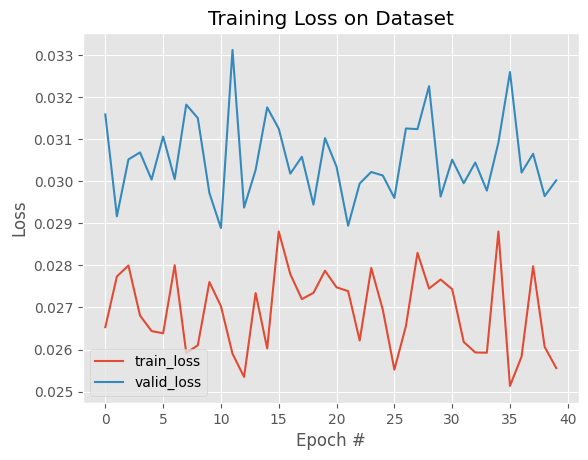

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["valid_loss"], label="valid_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")



### 04 - Testing

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [ ]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = InferenceDataset(test_images, test_dir, transform=test_transform,)

In [ ]:
predictions = predict(model, params, test_dataset, batch_size=8)

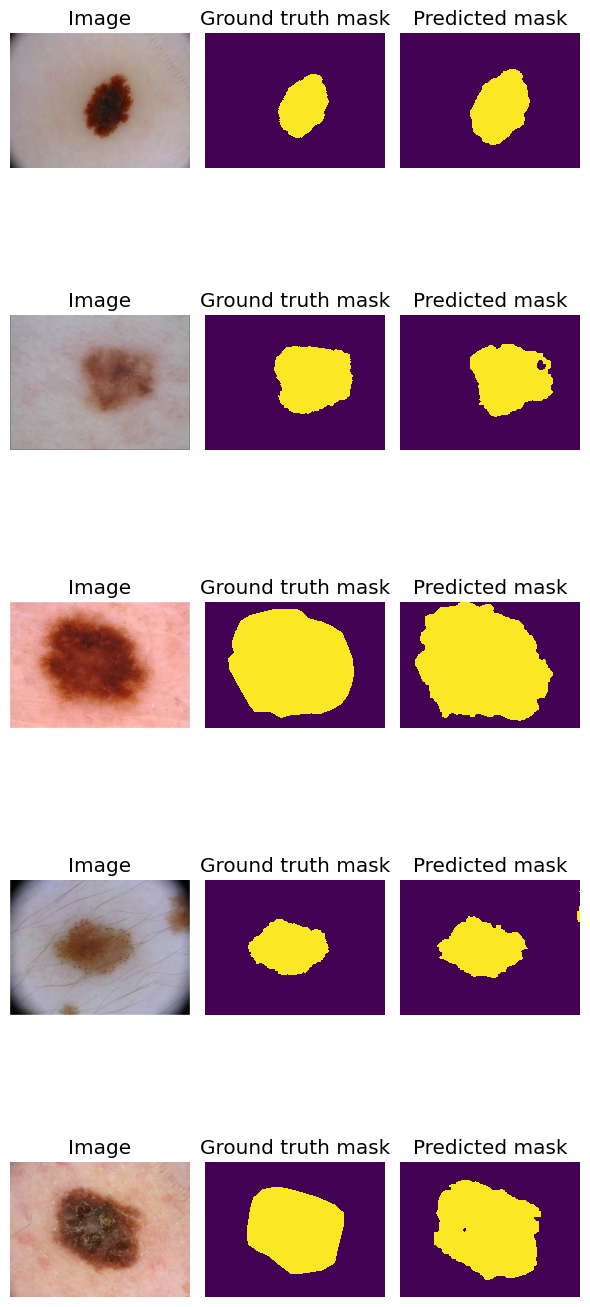

In [ ]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    target_size = (original_width,original_height)  # replace with your target size
    full_sized_mask = cv2.resize(predicted_256x256_mask, target_size, interpolation = cv2.INTER_NEAREST)

    predicted_masks.append(full_sized_mask)

display_image_grid(test_images, test_dir, test_masks, predicted_masks=predicted_masks)